In [1]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [2]:
%pwd

'C:\\Users\\Samuel Yow\\Desktop\\my_projects\\ARC\\Repo\\FishDetection'

In [3]:
# Load pipeline config and build a detection model
pipeline_config_path = os.path.join("ModelEfficinetNetd25ksteps","pipeline.config")
latest_check_point_path = os.path.join("ModelEfficinetNetd25ksteps","checkpoint","ckpt-0")
label_map_path = os.path.join("ModelEfficinetNetd25ksteps","label_map.pbtxt")


configs = config_util.get_configs_from_pipeline_file(pipeline_config_path)
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(latest_check_point_path).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

In [4]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
category_index = label_map_util.create_category_index_from_labelmap(label_map_path)

In [6]:
def show_img(IMAGE_PATH):    
    img = cv2.imread(IMAGE_PATH)
    image_np = np.array(img)

    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)

    fig, ax = plt.subplots(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
    plt.show()

In [7]:
TEST_PATH = os.path.join("TestImage")
list_of_files = []
for files in os.listdir(TEST_PATH):
    if files.endswith('jpg'):
        print(files)
        list_of_files.append(files)

000c172e9a038ca3.jpg
51df3dc1bc636ef5.jpg
53cb560cf915c067.jpg
6dd958a851bbcf37.jpg
9de4bc68a17778b4.jpg


In [8]:
for i in range(len(list_of_files)):
    list_of_files[i] = os.path.join(TEST_PATH,list_of_files[i])

In [9]:
IMAGE_PATH1 = os.path.join(TEST_PATH,"6dd958a851bbcf37.jpg")
IMAGE_PATH2 = os.path.join(TEST_PATH,"51df3dc1bc636ef5.jpg")

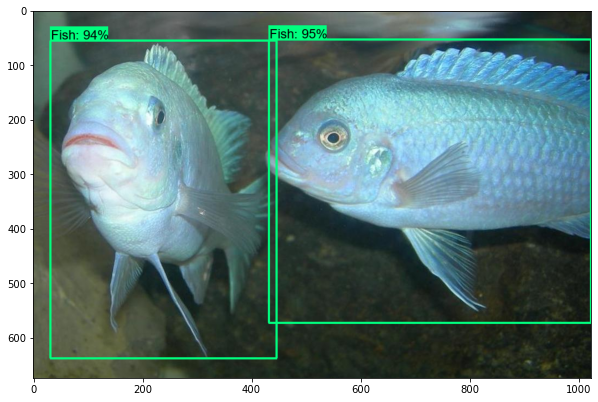

In [10]:
show_img(list_of_files[0])

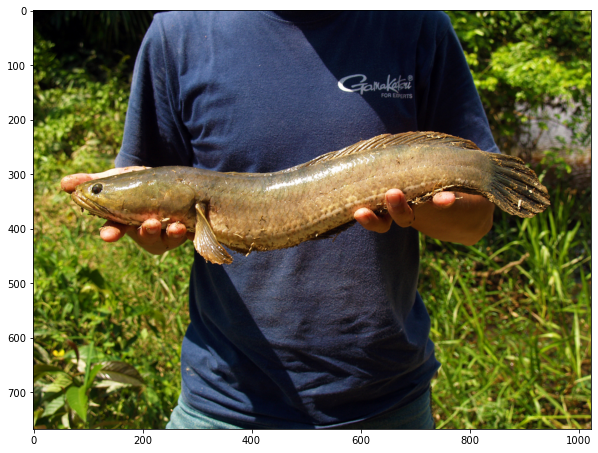

In [10]:
show_img(list_of_files[1])

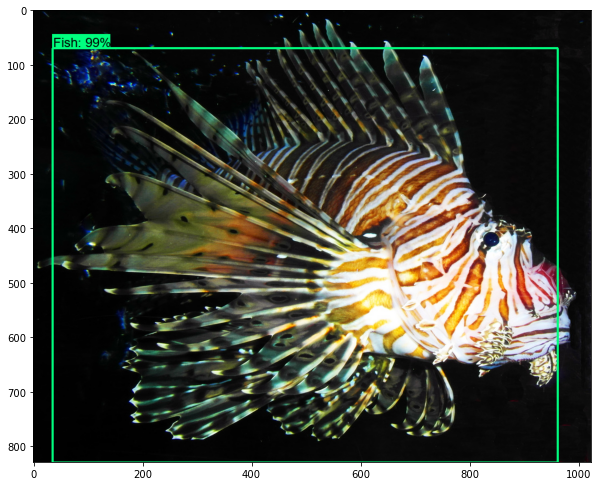

In [11]:
show_img(list_of_files[2])

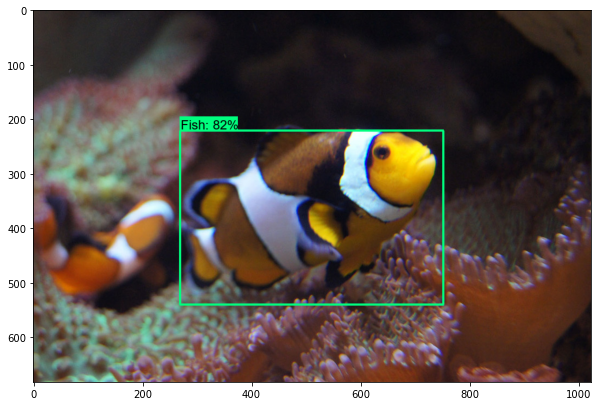

In [13]:
show_img(list_of_files[3])

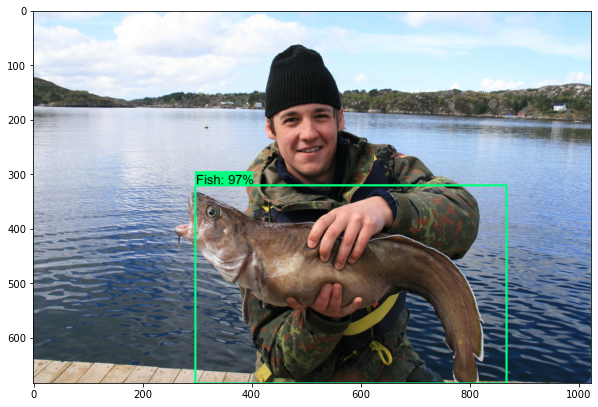

In [14]:
show_img(list_of_files[4])

In [11]:
cap = cv2.VideoCapture(os.path.join(TEST_PATH,'video1.mp4'))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)

    if ret:
        cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
        if cv2.waitKey(10) & 0xFF == ord('q'):
            cap.release()
            cv2.destroyAllWindows()
            break
    else:
        break
        
cap.release()
cv2.destroyAllWindows()